In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

<Figure size 640x480 with 7 Axes>

In [3]:
from sklearn import preprocessing 
import pandas as pd
import numpy as np
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (columns[j], j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (columns[j], j + 1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (columns[j], j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg

# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)

In [4]:
values = dataset.values
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaled = scaler.fit_transform(values[:,[1,2,3,4,5,6,7]])
#scaled = np.array(values[:,0],scaled.data)
scaled = np.c_[values[:,0],scaled]
scaled

array([[1.2900000e+02, 3.5294122e-01, 2.4590163e-01, ..., 2.2900114e-03,
        0.0000000e+00, 0.0000000e+00],
       [1.4800000e+02, 3.6764708e-01, 2.4590163e-01, ..., 3.8109892e-03,
        0.0000000e+00, 0.0000000e+00],
       [1.5900000e+02, 4.2647061e-01, 2.2950819e-01, ..., 5.3319666e-03,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+01, 2.6470590e-01, 2.6229507e-01, ..., 4.1399646e-01,
        0.0000000e+00, 0.0000000e+00],
       [8.0000000e+00, 2.6470590e-01, 2.4590163e-01, ..., 4.2086649e-01,
        0.0000000e+00, 0.0000000e+00],
       [1.2000000e+01, 2.7941179e-01, 2.6229507e-01, ..., 4.2621556e-01,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [5]:
columns = ['pollution',  'dew',  'temp',   'press', 'wnd_dir',  'wnd_spd',  'snow',  'rain']
# frame as supervised learning
reframed = series_to_supervised(scaled,columns, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   pollution1(t-1)  dew2(t-1)  temp3(t-1)  press4(t-1)  wnd_dir5(t-1)  \
1            129.0   0.352941    0.245902     0.527273       0.666667   
2            148.0   0.367647    0.245902     0.527273       0.666667   
3            159.0   0.426471    0.229508     0.545454       0.666667   
4            181.0   0.485294    0.229508     0.563637       0.666667   
5            138.0   0.485294    0.229508     0.563637       0.666667   

   wnd_spd6(t-1)  snow7(t-1)  rain8(t-1)  pollution1(t)  
1       0.002290    0.000000         0.0          148.0  
2       0.003811    0.000000         0.0          159.0  
3       0.005332    0.000000         0.0          181.0  
4       0.008391    0.037037         0.0          138.0  
5       0.009912    0.074074         0.0          109.0  


In [6]:
label_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
reframed['pollution1(t-1)'] =label_scaler.fit_transform(reframed.values[:,0].reshape(-1, 1))

In [7]:
reframed['pollution1(t)'] =label_scaler.fit_transform(reframed.values[:,8].reshape(-1, 1))#arima no##to dnn regress#

In [8]:
#only sklearn
import sklearn
reframed = sklearn.utils.shuffle(reframed)
reframed.drop(reframed.columns[[6]], axis=1, inplace=True)

In [16]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 3#24*30
train = values[:n_train_hours, :]#:n
test = values[n_train_hours:, :]#n:

In [17]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 7) (26280,) (17519, 1, 7) (17519,)


regress sklearn

In [18]:
train_X = train_X.reshape((train_X.shape[0],  train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

1.linear

In [25]:
from sklearn import preprocessing,svm
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import *
regressor = BaggingRegressor(random_state=0, n_estimators=10)
#RandomForestRegressor(n_estimators = 10,random_state=0,max_depth = 5)
#DecisionTreeRegressor(max_depth=5,random_state=1)
#LinearRegression(n_jobs = -1)
regressor.fit(train_X, train_y)
regressor.score(test_X,test_y)

0.8928003934154138

2.ridgeRegression

In [24]:
from sklearn.linear_model import Ridge,Lasso
alphas = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
scores = []
for i, alpha in enumerate(alphas):
    regressor = Ridge(alpha=alpha)#Ridge
    regressor.fit(train_X, train_y)
    scores.append(regressor.score(test_X, test_y))
for i in range(len(alphas)):
    print(alphas[i], scores[i])

0.01 0.9133084943725023
0.02 0.9133081067517687
0.05 0.9133069190630858
0.1 0.913304854495501
0.2 0.9133004160075541
0.5 0.9132846004402531
1 0.9132500278329284
2 0.9131508291986337
5 0.9126270264890566
10 0.9110845656950353
20 0.9060044125779712
50 0.8813364586092036
100 0.8291760019542943
200 0.7279951185940399
500 0.5237914027104122
1000 0.35961772941133874


In [25]:
regressor = Ridge(alpha=0.1)
regressor.fit(train_X, train_y)
regressor.score(test_X, test_y)

0.913304854495501

svm

In [45]:
from sklearn.svm import SVR
regressor = SVR(C = 1000,kernel = 'linear')
regressor.fit(train_X, train_y) 
regressor.score(test_X, test_y)

0.8685959390104228

In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import explained_variance_score, make_scorer
parameters = [{'C':[1,10,100,1000],'kernel':['linear']},
              {'C':[1,10,100,1000],'kernel':['rbf'],'gamma':[0.5,0.1,0.01,0.001,0.0001]}
             ]
scoring_function = make_scorer(explained_variance_score)
grid = GridSearchCV(estimator = regressor,
                   param_grid = parameters,
                   scoring = scoring_function,#'accuracy',
                   cv = 10,
                   n_jobs = -1)
regressor_g = grid.fit(train_X, train_y)

AttributeError: 'GridSearchCV' object has no attribute 'best_param_'

In [46]:
best_ac = grid.best_score_
regressor_g.best_params_

{'C': 1000, 'kernel': 'linear'}

predict

In [47]:
from sklearn.model_selection import cross_val_score
X = np.append(train_X,test_X,axis = 0)
y = np.append(train_y,test_y)
score = cross_val_score(regressor, X, y, cv=10)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.88 (+/- 0.02)


In [48]:
yhat = regressor.predict(test_X)
print("W:%s, b:%.2f" % (regressor.coef_, regressor.intercept_))
print("LOSS:%.2f" % np.mean((regressor.predict(test_X) - test_y) ** 2))

W:[[ 0.7644573   0.03777064 -0.09777581 -0.01908066  0.02473346 -0.10699811
  -0.11361544]], b:0.06
LOSS:0.00


In [21]:
import statsmodels.api as sm
X = sm.add_constant(X)  

In [22]:
alpha = 0.05

model = sm.OLS(y, X).fit()

model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.914
Method:                 Least Squares   F-statistic:                 6.640e+04
Date:                Wed, 31 Jul 2019   Prob (F-statistic):               0.00
Time:                        15:09:00   Log-Likelihood:                 95673.
No. Observations:               43799   AIC:                        -1.913e+05
Df Residuals:                   43791   BIC:                        -1.913e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0053      0.001      4.130      0.000       0.003       0.008
x1             0.9405      0.002    589.218      0.000       0.937       0.944
x2             0.0110      0.001      8.583      0.000       0.008       0.013
x3            -0.0176      0.001    -11.848      0.000      -0.020      -0.015
x4            -0.0039      0.001     -2.946      0.003      -0.006      -0.001
x5             0.0086      0.000     19.579      0.000       0.008       0.009
x6            -0.0057      0.002     -3.463      0.001      -0.009      -0.002
x7            -0.0205      0.003     -6.053      0.000      -0.027      -0.014
==============================================================================
Omnibus:                    18976.933   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         24334986.238
Skew:                          -0.462   Prob(JB):                         0.00
Kurtosis:                     118.472   Cond. No.                         39.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

dnn regress

In [10]:
import pandas as pd  
import numpy as np  
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,median_absolute_error
from sklearn.model_selection import train_test_split  

In [11]:
reframed.rename(columns = {"pollution1(t-1)":"prepollution", 
                        "dew2(t-1)": "dew",
                        'temp3(t-1)':'temp',
                        'press4(t-1)':'press',
                        'wnd_dir5(t-1)':'wnddir',
                        'wnd_spd6(t-1)':'wnd_spd',
                        'snow7(t-1)':'snow',
                        'rain8(t-1)':'rain',
                        'pollution1(t)':'pollution'},inplace = True) 

In [12]:
X = reframed.drop(['pollution'], axis=1)
y = reframed['pollution']
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)  
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)
feature_attr = [tf.feature_column.numeric_column(col) for col in X.columns] 

In [13]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_attr,
                                      hidden_units=[50, 50],#5050
#                                      dropout=0.2,
                                      activation_fn=tf.nn.relu,
#                                      optimizer=tf.train.AdamOptimizer(learning_rate=0.35),
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_protocol': None, '_save_checkpoints_secs': 600, '_model_dir': 'tf_wx_model', '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_service': None, '_task_type': 'worker', '_is_chief': True, '_num_worker_replicas': 1, '_save_summary_steps': 100, '_tf_random_seed': None, '_save_checkpoints_steps': None, '_master': '', '_evaluation_master': '', '_experimental_distribute': None, '_global_id_in_cluster': 0, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002076BEE7D30>, '_train_distribute': None, '_log_step_count_steps': 100, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_device_fn': None, '_task_id': 0, '_eval_distribute': None}


In [14]:
def data_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=400):
    return tf.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [15]:
evaluations = []
STEPS = 200
for i in range(100):
    regressor.train(input_fn=data_input_fn(X_train, y=y_train), steps=STEPS)
    evaluation = regressor.evaluate(input_fn=data_input_fn(X_val, y_val,
                                                         num_epochs=1,
                                                         shuffle=False),
                                    steps=1)
    evaluations.append(regressor.evaluate(input_fn=data_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=True)))

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 35.32736, step = 0
INFO:tensorflow:global_step/sec: 188.291
INFO:tensorflow:loss = 0.23941053, step = 100 (0.533 sec)
INFO:tensorflow:Saving checkpoints for 200 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.6275631.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:37:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflo

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:37:20
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:37:20
INFO:tensorflow:Saving dict for global step 800: average_loss = 0.0008151151, global_step = 800, label/mean = 0.094546035, loss = 0.324564, prediction/mean = 0.09822565
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 800: tf_wx_model\model.ckpt-800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 800 into tf_wx_model\model.ckpt.
INFO:tenso

INFO:tensorflow:Finished evaluation at 2019-07-31-04:37:34
INFO:tensorflow:Saving dict for global step 1600: average_loss = 0.00085102837, global_step = 1600, label/mean = 0.09454604, loss = 0.33886403, prediction/mean = 0.101726286
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1600: tf_wx_model\model.ckpt-1600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-1600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1600 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.15039948, step = 1600
INFO:tensorflow:global_step/sec: 158.902
INFO:tensorflow:loss = 0.2512186, step = 1700 (0.630 sec)
INFO:tensorflow:Saving checkpoints for 1800 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.40657285.
INFO:tensorflow:Call

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-2400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 2400 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.45248574, step = 2400
INFO:tensorflow:global_step/sec: 154.612
INFO:tensorflow:loss = 0.3169669, step = 2500 (0.648 sec)
INFO:tensorflow:Saving checkpoints for 2600 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.16351087.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:37:52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-2600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3200 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.16855839, step = 3200
INFO:tensorflow:global_step/sec: 199.533
INFO:tensorflow:loss = 0.31304616, step = 3300 (0.502 sec)
INFO:tensorflow:Saving checkpoints for 3400 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.22025034.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:38:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-3400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:38:08
INFO:tensorflow:Saving dict for global step 3400: average_loss = 0.00067605765, global_step = 3400, label/mean = 0.095213786, loss = 0.27042305, prediction/mean = 0.09010499
INFO:tensorflow:Saving 'ch

INFO:tensorflow:Saving checkpoints for 4200 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.315698.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:38:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-4200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:38:23
INFO:tensorflow:Saving dict for global step 4200: average_loss = 0.0006503615, global_step = 4200, label/mean = 0.095213786, loss = 0.2601446, prediction/mean = 0.094497465
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4200: tf_wx_model\model.ckpt-4200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:38:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:38:37
INFO:tensorflow:Saving dict for global step 5000: average_loss = 0.0006603387, global_step = 5000, label/mean = 0.095213786, loss = 0.26413548, prediction/mean = 0.09848178
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: tf_wx_model\model.ckpt-5000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:38:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:38:38
INFO:tensorflow:Saving dict for global step 5000: average_loss = 

INFO:tensorflow:Saving dict for global step 5800: average_loss = 0.0006578649, global_step = 5800, label/mean = 0.095213786, loss = 0.26314595, prediction/mean = 0.09246064
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5800: tf_wx_model\model.ckpt-5800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:38:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-5800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:38:52
INFO:tensorflow:Saving dict for global step 5800: average_loss = 0.00080296816, global_step = 5800, label/mean = 0.09454604, loss = 0.31972733, prediction/mean = 0.092311285
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5800: tf_wx_model\model.ckpt-5800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:39:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-6600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:39:07
INFO:tensorflow:Saving dict for global step 6600: average_loss = 0.0008005628, global_step = 6600, label/mean = 0.094546035, loss = 0.31876954, prediction/mean = 0.09633394
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6600: tf_wx_model\model.ckpt-6600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-6600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 6

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:39:21
INFO:tensorflow:Saving dict for global step 7400: average_loss = 0.0007991298, global_step = 7400, label/mean = 0.094546035, loss = 0.31819895, prediction/mean = 0.0961292
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7400: tf_wx_model\model.ckpt-7400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-7400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 7400 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.13246964, step = 7400
INFO:tensorflow:global_step/sec: 196.335
INFO:tensorflow:loss = 0.251658, step = 7500 (0.509 sec)
INFO:tensorflow:Saving checkpoints for 7600 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for fin

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 8200: tf_wx_model\model.ckpt-8200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-8200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8200 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.5897366, step = 8200
INFO:tensorflow:global_step/sec: 184.744
INFO:tensorflow:loss = 0.3340982, step = 8300 (0.542 sec)
INFO:tensorflow:Saving checkpoints for 8400 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.22574306.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:39:38
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-8400
INFO:tensorflow

INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 9000 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.20144746, step = 9000
INFO:tensorflow:global_step/sec: 157.158
INFO:tensorflow:loss = 0.21782984, step = 9100 (0.638 sec)
INFO:tensorflow:Saving checkpoints for 9200 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.19131702.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:39:53
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-9200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:39:53
INFO:tensorflow:Saving dict for global step 9200: average_loss = 0.0006480593, global_step 

INFO:tensorflow:Loss for final step: 0.2457115.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:40:32
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-10800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:40:33
INFO:tensorflow:Saving dict for global step 10800: average_loss = 0.0006484687, global_step = 10800, label/mean = 0.095213786, loss = 0.25938746, prediction/mean = 0.09596252
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 10800: tf_wx_model\model.ckpt-10800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:40:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-10800
INFO:tensorflow:Runni

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:41:28
INFO:tensorflow:Saving dict for global step 12400: average_loss = 0.00064544025, global_step = 12400, label/mean = 0.095213786, loss = 0.2581761, prediction/mean = 0.094695084
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 12400: tf_wx_model\model.ckpt-12400
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:41:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-12400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:41:30
INFO:tensorflow:Saving dict for global step 12400: average_loss = 0.0007955718, global_step = 12400, label/mean = 0.09454604, loss = 0.3167822, prediction/mean = 0.09454959
INFO:tensorflow:Saving 'checkpoi

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13200: tf_wx_model\model.ckpt-13200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:41:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-13200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:41:52
INFO:tensorflow:Saving dict for global step 13200: average_loss = 0.0007943234, global_step = 13200, label/mean = 0.09454605, loss = 0.31628513, prediction/mean = 0.09426975
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 13200: tf_wx_model\model.ckpt-13200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-13200
INFO:tensorflow:R

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:42:11
INFO:tensorflow:Saving dict for global step 14000: average_loss = 0.00080712495, global_step = 14000, label/mean = 0.094546035, loss = 0.3213825, prediction/mean = 0.09801904
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 14000: tf_wx_model\model.ckpt-14000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 14000 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.23687428, step = 14000
INFO:tensorflow:global_step/sec: 172.58
INFO

INFO:tensorflow:Saving 'checkpoint_path' summary for global step 15600: tf_wx_model\model.ckpt-15600
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-15600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 15600 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.19054928, step = 15600
INFO:tensorflow:global_step/sec: 157.159
INFO:tensorflow:loss = 0.22359113, step = 15700 (0.637 sec)
INFO:tensorflow:Saving checkpoints for 15800 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.27443126.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:42:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-15800
INFO:

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-16400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 16400 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.26120526, step = 16400
INFO:tensorflow:global_step/sec: 183.977
INFO:tensorflow:loss = 0.18025604, step = 16500 (0.545 sec)
INFO:tensorflow:Saving checkpoints for 16600 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.36432996.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:43:03
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-16600
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:43:03
INFO:tensorflow:Saving dict for global step 1660

INFO:tensorflow:Saving checkpoints for 17200 into tf_wx_model\model.ckpt.
INFO:tensorflow:loss = 0.233607, step = 17200
INFO:tensorflow:global_step/sec: 193.533
INFO:tensorflow:loss = 0.17784123, step = 17300 (0.518 sec)
INFO:tensorflow:Saving checkpoints for 17400 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.45432013.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:43:18
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-17400
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:43:18
INFO:tensorflow:Saving dict for global step 17400: average_loss = 0.0006567739, global_step = 17400, label/mean = 0.095213786, loss = 0.26270956, prediction/mean = 0.098600075
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 

INFO:tensorflow:Saving checkpoints for 18200 into tf_wx_model\model.ckpt.
INFO:tensorflow:Loss for final step: 0.2561588.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:43:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-18200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:43:34
INFO:tensorflow:Saving dict for global step 18200: average_loss = 0.00065097975, global_step = 18200, label/mean = 0.095213786, loss = 0.2603919, prediction/mean = 0.09591073
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 18200: tf_wx_model\model.ckpt-18200
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:43:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Re

INFO:tensorflow:Starting evaluation at 2019-07-31-04:43:50
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:43:50
INFO:tensorflow:Saving dict for global step 19000: average_loss = 0.0006483767, global_step = 19000, label/mean = 0.095213786, loss = 0.2593507, prediction/mean = 0.09388664
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 19000: tf_wx_model\model.ckpt-19000
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:43:51
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:43:51
I

INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [1/1]
INFO:tensorflow:Finished evaluation at 2019-07-31-04:44:06
INFO:tensorflow:Saving dict for global step 19800: average_loss = 0.00065002573, global_step = 19800, label/mean = 0.095213786, loss = 0.2600103, prediction/mean = 0.093477875
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 19800: tf_wx_model\model.ckpt-19800
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-07-31-04:44:06
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-19800
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-07-31-04:44:06
INFO:tensorflow:Saving dict for global step 19800: average_loss = 0.0007957838, global_step = 19800, label/mean = 0.09454604, loss = 0.31686667, prediction/mean = 0.09336237
INFO:tensorflow:Saving 'checkpo

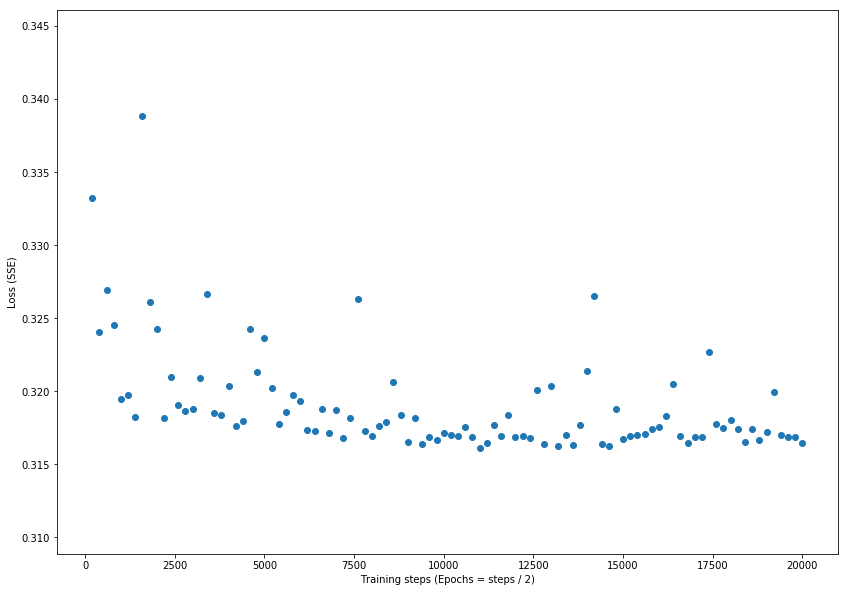

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

In [17]:
pred = regressor.predict(input_fn=data_input_fn(X_test,num_epochs=1,shuffle=False))
yhat = np.array([p['predictions'][0] for p in pred])
test_y = y_test.values

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model\model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [19]:
train_spec = tf.estimator.TrainSpec(input_fn=data_input_fn(X_train, y=y_train,num_epochs=1,shuffle=True), max_steps=1000)
eval_spec = tf.estimator.EvalSpec(input_fn=data_input_fn(X_test,y = y_test,num_epochs=1,shuffle=True))

In [ ]:
tf.estimator.train_and_evaluate(regressor, train_spec, eval_spec)

arima(sarimax) (not need normo)

In [13]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [14]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(label_scaler.inverse_transform(train_y.reshape(-1, 1)), label="Actual (%s)" % 'pollution1(t)')
pyplot.legend()

In [11]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    rol_mean = timeSeries.rolling(window=size).mean()
    rol_weighted_mean = pd.ewma(timeSeries, span=size)
 
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
 
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()
 
def testStationarity(ts):
    dftest = adfuller(ts)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput
 
def draw_acf_pacf(ts, lags=50):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=50, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=50, ax=ax2, alpha=0.05)
    plt.show()

In [12]:
testStationarity(train_y)

Test Statistic                -6.249814e+00
p-value                        4.482621e-08
#Lags Used                     5.000000e+00
Number of Observations Used    1.434000e+03
Critical Value (1%)           -3.434918e+00
Critical Value (5%)           -2.863558e+00
Critical Value (10%)          -2.567844e+00
dtype: float64

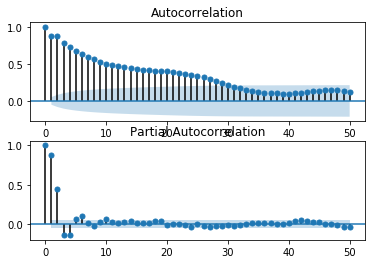

In [13]:
%matplotlib inline
draw_acf_pacf(train_y)

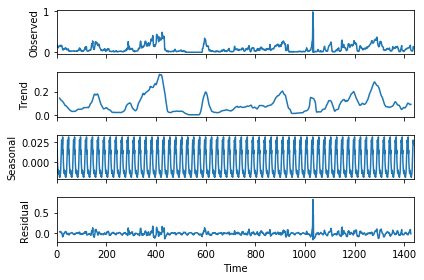

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(train_y, model="additive",freq = 24)#multiplicative

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
#residual = pd.DataFrame(residual)
#train_y_diff1 = residual.diff(1)
#train_y_diff1.dropna(inplace=True)
#testStationarity(train_y_diff1.values.reshape(1,-1)[0])
fig = decomposition.plot()
plt.show()

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


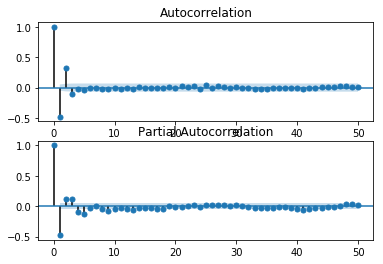

In [20]:
%matplotlib inline
train_y_log = np.log(train_y)
train_y_d = pd.DataFrame(train_y)
train_y_diff1 = train_y_d.diff(1)
train_y_diff1.dropna(inplace=True)
draw_acf_pacf(train_y_diff1)

In [22]:
# Define the p, d and q parameters to take any value between 0 and 2
p = range(0, 5)
d = range(0, 2)
q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in list(itertools.product(p, d, q))]#12

In [23]:
warnings.filterwarnings("ignore") # specify to ignore warning messages
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 4) - AIC:-1875.8626772671223
ARIMA(0, 0, 0)x(0, 0, 1, 4) - AIC:-2879.0803321977683
ARIMA(0, 0, 0)x(0, 1, 0, 4) - AIC:-3752.716494848413
ARIMA(0, 0, 0)x(0, 1, 1, 4) - AIC:-3821.601685142523
ARIMA(0, 0, 0)x(1, 0, 0, 4) - AIC:-3855.3102911522856
ARIMA(0, 0, 0)x(1, 0, 1, 4) - AIC:-3885.2283306359777
ARIMA(0, 0, 0)x(1, 1, 0, 4) - AIC:-3790.3905206270856
ARIMA(0, 0, 0)x(1, 1, 1, 4) - AIC:-3919.8813061375445
ARIMA(0, 0, 0)x(2, 0, 0, 4) - AIC:-3861.9205975801956
ARIMA(0, 0, 0)x(2, 0, 1, 4) - AIC:-3918.3571432375093
ARIMA(0, 0, 0)x(2, 1, 0, 4) - AIC:-3823.5862658474366
ARIMA(0, 0, 0)x(2, 1, 1, 4) - AIC:-3910.8904423278927
ARIMA(0, 0, 0)x(3, 0, 0, 4) - AIC:-3875.6687235419904
ARIMA(0, 0, 0)x(3, 0, 1, 4) - AIC:-3908.5782911174815
ARIMA(0, 0, 0)x(3, 1, 0, 4) - AIC:-3849.20338783428
ARIMA(0, 0, 0)x(3, 1, 1, 4) - AIC:-3871.203572434498
ARIMA(0, 0, 0)x(4, 0, 0, 4) - AIC:-3887.6738927246734
ARIMA(0, 0, 0)x(4, 0, 1, 4) - AIC:-3898.279984748909
ARIMA(0, 0, 0)x(4, 1, 0, 4) - AIC:

ARIMA(1, 1, 1)x(3, 1, 1, 4) - AIC:-5223.6888147285945
ARIMA(1, 1, 1)x(4, 0, 0, 4) - AIC:-5245.656444509855
ARIMA(1, 1, 1)x(4, 0, 1, 4) - AIC:-5243.708801972357
ARIMA(1, 1, 1)x(4, 1, 0, 4) - AIC:-4898.498119323607
ARIMA(1, 1, 1)x(4, 1, 1, 4) - AIC:-5189.961363732239
ARIMA(2, 0, 0)x(0, 0, 0, 4) - AIC:-5271.422457035551
ARIMA(2, 0, 0)x(0, 0, 1, 4) - AIC:-5282.556082499546
ARIMA(2, 0, 0)x(0, 1, 0, 4) - AIC:-4287.346160399519
ARIMA(2, 0, 0)x(0, 1, 1, 4) - AIC:-5237.093830193128
ARIMA(2, 0, 0)x(1, 0, 0, 4) - AIC:-5273.989548512502
ARIMA(2, 0, 0)x(1, 0, 1, 4) - AIC:-5284.247411547621
ARIMA(2, 0, 0)x(1, 1, 0, 4) - AIC:-4642.020398411078
ARIMA(2, 0, 0)x(1, 1, 1, 4) - AIC:-5247.3411800790955
ARIMA(2, 0, 0)x(2, 0, 0, 4) - AIC:-5262.851408474502
ARIMA(2, 0, 0)x(2, 0, 1, 4) - AIC:-5265.798125915029
ARIMA(2, 0, 0)x(2, 1, 0, 4) - AIC:-4793.98954766422
ARIMA(2, 0, 0)x(2, 1, 1, 4) - AIC:-5235.102644147686
ARIMA(2, 0, 0)x(3, 0, 0, 4) - AIC:-5247.755075243573
ARIMA(2, 0, 0)x(3, 0, 1, 4) - AIC:-5246.71140

ARIMA(3, 1, 1)x(2, 1, 0, 4) - AIC:-4753.060477577912
ARIMA(3, 1, 1)x(2, 1, 1, 4) - AIC:-5236.415231253155
ARIMA(3, 1, 1)x(3, 0, 0, 4) - AIC:-5259.311668814299
ARIMA(3, 1, 1)x(3, 0, 1, 4) - AIC:-5258.506502120673
ARIMA(3, 1, 1)x(3, 1, 0, 4) - AIC:-4847.772065054309
ARIMA(3, 1, 1)x(3, 1, 1, 4) - AIC:-5220.213384442002
ARIMA(3, 1, 1)x(4, 0, 0, 4) - AIC:-5240.483572624084
ARIMA(3, 1, 1)x(4, 0, 1, 4) - AIC:-5238.812790005011
ARIMA(3, 1, 1)x(4, 1, 0, 4) - AIC:-4909.868687621944
ARIMA(3, 1, 1)x(4, 1, 1, 4) - AIC:-5169.671130365163
ARIMA(4, 0, 0)x(0, 0, 0, 4) - AIC:-5305.329172611555
ARIMA(4, 0, 0)x(0, 0, 1, 4) - AIC:-5323.755745726862
ARIMA(4, 0, 0)x(0, 1, 0, 4) - AIC:-4656.042950753879
ARIMA(4, 0, 0)x(0, 1, 1, 4) - AIC:-5291.21019890012
ARIMA(4, 0, 0)x(1, 0, 0, 4) - AIC:-5307.205487888721
ARIMA(4, 0, 0)x(1, 0, 1, 4) - AIC:-5311.668554703517
ARIMA(4, 0, 0)x(1, 1, 0, 4) - AIC:-4834.579894527862
ARIMA(4, 0, 0)x(1, 1, 1, 4) - AIC:-5289.979829841728
ARIMA(4, 0, 0)x(2, 0, 0, 4) - AIC:-5292.1039373

In [15]:
mod = sm.tsa.statespace.SARIMAX(train_y,
                                order=(4, 1, 1),
                                seasonal_order=(0, 0, 0, 4),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

D:\Anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4617      0.032     14.500      0.000       0.399       0.524
ar.L2          0.5668      0.021     27.217      0.000       0.526       0.608
ar.L3         -0.0787      0.011     -7.215      0.000      -0.100      -0.057
ar.L4         -0.1637      0.010    -15.620      0.000      -0.184      -0.143
ma.L1         -0.9254      0.032    -29.188      0.000      -0.988      -0.863
sigma2         0.0014   8.89e-06    159.359      0.000       0.001       0.001


testdata(預設滾動預測，要一直加資料往下預測)

In [17]:
yhat = []
pa = results.params
for i in range(len(test_y)):
    last_obs = mod.data.endog[-1]
    observations = [last_obs, test_y[i]]
    mod = sm.tsa.SARIMAX(observations, order=(4, 1, 1),seasonal_order=(0, 0, 0, 4),)#np.hstack((train_y,test_y))
    res = mod.filter(pa)#mod2.smooth(results.params)
    yhat.append(res.forecast(steps=1)[0])
    pa = res.params
yhat

[0.10345613014391494,
 0.09500142018548417,
 0.12666529183522074,
 0.16929006535017505,
 0.1568512820122278,
 0.12341126404094357,
 0.1132204715002531,
 0.11830585098110222,
 0.12431446635102625,
 0.1303782838716739,
 0.14052144367175443,
 0.15670081820777254,
 0.18511822402276504,
 0.21769020039632567,
 0.24017421529304114,
 0.24280593843024628,
 0.23277318252282128,
 0.2268197652717368,
 0.2062298548937811,
 0.16900651580634912,
 0.14780452186785453,
 0.13401604017841123,
 0.12942744882098128,
 0.1162034139195829,
 0.10014199798956863,
 0.10522737747041776,
 0.11795462404400112,
 0.12624373923712157,
 0.12368725182963228,
 0.12276401594055736,
 0.12529290418642894,
 0.12934464771303586,
 0.12920665190494734,
 0.14226508438605898,
 0.17296299022864373,
 0.2051837507387762,
 0.23011386022399843,
 0.24618283811354577,
 0.2400838598805391,
 0.2299482652542923,
 0.22774299753771934,
 0.2357436607732725,
 0.2552371710867293,
 0.25999135720946953,
 0.25702844454164375,
 0.26067377025849475,

In [18]:
yhat = np.array(yhat)

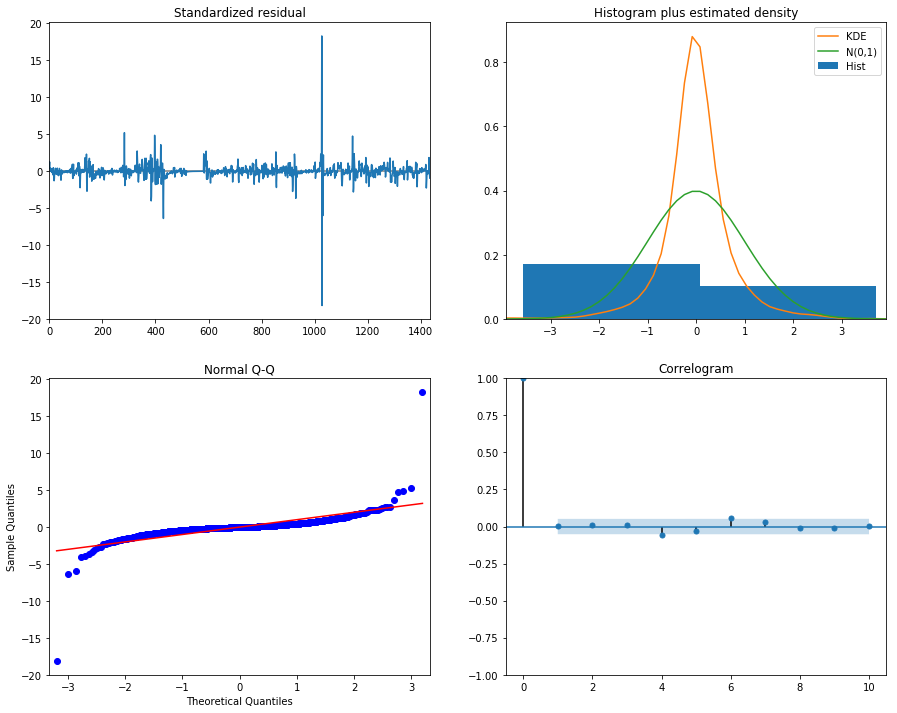

In [16]:
%matplotlib inline
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [19]:
pred = results.get_prediction(dynamic=False)
#pred = results.get_prediction(dynamic=True)
pred_ci = pred.conf_int()

In [20]:
df_y = pd.DataFrame(train_y)
df_pred_predicted_mean = pd.DataFrame(pred.predicted_mean)
df_pred_ci = pd.DataFrame(pred_ci)

In [21]:
%matplotlib qt5
ax = df_y.plot(label='observed')
df_pred_predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

#ax.fill_between(df_pred_ci.index,
#                df_pred_ci.iloc[:, 0],
#                df_pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('pm2.5')
plt.legend()

plt.show()

In [58]:
import math
rmse = math.sqrt(((train_y - pred.predicted_mean) ** 2).mean())
print(rmse)

0.037864207059544866


evalute

In [26]:
def to_class(pre_pm):
    if pre_pm <= 11:
        return 0
    elif 11 < pre_pm <= 23:
        return  1
    elif 23 < pre_pm <= 35:
        return  2
    elif 35 < pre_pm <= 41:
        return  3
    elif 41 < pre_pm <= 47:
        return  4
    elif 47 < pre_pm <= 53:
        return  5
    elif 53 < pre_pm <= 58:
        return  6
    elif 58 < pre_pm <= 64:
        return  7
    elif 64 < pre_pm <= 70:
        return  8
    elif 70 < pre_pm:
        return  9

In [51]:
count = 0

for i in range(len(yhat)):
    after_pm = label_scaler.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scaler.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    #after_pm = yhat[i]
    #pre_pm = test_y[i]
    if to_class(after_pm) == to_class(pre_pm) :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
        count = count + 1
print(count/len(yhat))

0.6951880815115018


In [24]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(label_scaler.inverse_transform(test_y.reshape(-1, 1)), label="Actual (%s)" % 'pollution1(t)')
pyplot.plot(label_scaler.inverse_transform(yhat.reshape(-1, 1)), label="Predicted (%s)" % 'pollution1(t)')
pyplot.legend()
#pyplot.show()
#pyplot.savefig('test.png')

In [32]:
from sklearn.metrics import explained_variance_score, mean_absolute_error,median_absolute_error
print("The Explained Variance: %.2f" % explained_variance_score(
                                            test_y, yhat))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            test_y, yhat))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            test_y, yhat))

The Explained Variance: 0.92
The Mean Absolute Error: 0.01 degrees Celcius
The Median Absolute Error: 0.01 degrees Celcius
